<a href="https://colab.research.google.com/github/zeph0yr/Design-and-Analysis-of-Algorithms/blob/master/Decision%20tree%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

In [0]:
df_final = pd.read_csv("AAPL.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)
#feature scaling
#from sklearn.preprocessing import MinMaxScaler
#sc = MinMaxScaler(feature_range = (0, 1))
#df= sc.fit_transform(df_final)

In [84]:
df_final.head()



,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-30,163.250000,166.149994,160.229996,165.250000,162.803864,61109800
2019-01-31,166.110001,169.000000,164.559998,166.440002,163.976242,40739600
2019-02-01,166.960007,168.979996,165.929993,166.520004,164.055069,32668100
2019-02-04,167.410004,171.660004,167.279999,171.250000,168.715042,31495500
2019-02-05,172.860001,175.080002,172.350006,174.179993,171.601685,36101600


In [85]:
df_final.shape


(253, 6)

In [86]:
df_final.describe()


,Open,High,Low,Close,Adj Close,Volume
count,253.000000,253.000000,253.000000,253.000000,253.000000,2.530000e+02
mean,220.159102,222.232292,218.543518,220.598419,219.533906,2.768743e+07
std,40.470905,40.761894,40.366856,40.741973,41.385308,9.858903e+06
min,163.250000,166.149994,160.229996,165.250000,162.803864,1.136200e+07
25%,191.809998,195.369995,191.050003,193.339996,191.967804,2.099050e+07
50%,205.860001,207.750000,203.860001,206.490005,205.084274,2.588170e+07
75%,247.240005,249.169998,242.570007,246.580002,245.841919,3.201060e+07
max,324.450012,327.850006,321.380005,324.339996,324.339996,6.928140e+07


In [87]:
df_final.isnull().values.any()


False

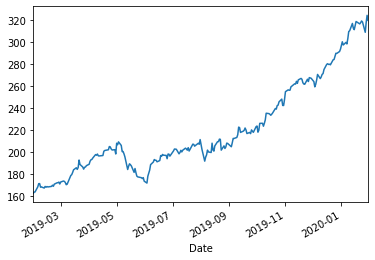

In [88]:
df_final['Adj Close'].plot()


In [0]:
X=df_final.drop(['Adj Close'],axis=1)
X=X.drop(['Close'],axis=1)

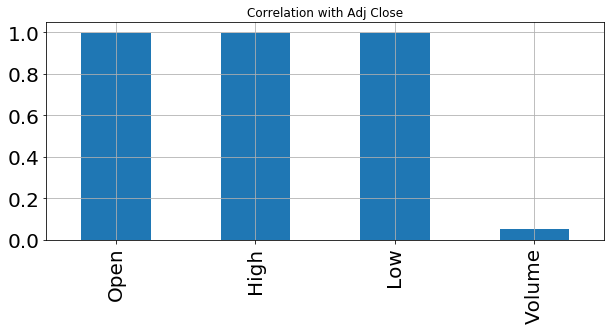

In [90]:
X.corrwith(df_final['Adj Close']).plot.bar(
        figsize = (10, 4), title = "Correlation with Adj Close", fontsize = 20,
        rot = 90, grid = True)

In [91]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Adj Close'])
display(test.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-30,163.250000,166.149994,160.229996,165.250000,162.803864,61109800
2019-01-31,166.110001,169.000000,164.559998,166.440002,163.976242,40739600
2019-02-01,166.960007,168.979996,165.929993,166.520004,164.055069,32668100
2019-02-04,167.410004,171.660004,167.279999,171.250000,168.715042,31495500
2019-02-05,172.860001,175.080002,172.350006,174.179993,171.601685,36101600


In [0]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

In [93]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
2019-01-30,0.000000,0.000000,0.000000,0.858914
2019-01-31,0.017742,0.017625,0.026869,0.507215
2019-02-01,0.023015,0.017502,0.035371,0.367858
2019-02-04,0.025806,0.034076,0.043748,0.347612
2019-02-05,0.059615,0.055226,0.075209,0.427138


In [0]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

In [0]:
s_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [97]:
X_train.shape


(67, 4)

In [98]:
X_test.shape


(6, 4)

In [99]:
y_train.shape



(67,)

In [100]:
y_test.shape


(6,)

In [0]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

RMSE:  6.976221623828571
R2 score:  0.6580988879319389


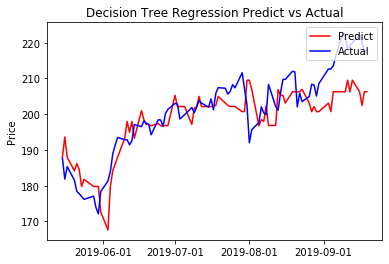

In [102]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

In [0]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [104]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
67/67 [==============================] - 1s 10ms/step - loss: 34615.4898
Epoch 2/200
67/67 [==============================] - 0s 417us/step - loss: 34608.9457
Epoch 3/200
67/67 [==============================] - 0s 368us/step - loss: 34602.4626
Epoch 4/200
67/67 [==============================] - 0s 399us/step - loss: 34596.0900
Epoch 5/200
67/67 [==============================] - 0s 401us/step - loss: 34589.6311
Epoch 6/200
67/67 [==============================] - 0s 413us/step - loss: 34582.7716
Epoch 7/200
67/67 [==============================] - 0s 434us/step - loss: 34575.4710
Epoch 8/200
67/67 [==============================] - 0s 474us/step - loss: 34567.7104
Epoch 9/200
67/67 [==============================] - 0s 412us/step - loss: 34559.5050
Epoch 10/200
67/67 [==============================] - 0s 423us/step - loss: 34550.8228
Epoch 11/200
67/67 [==============================] - 0s 418us/step - loss: 34541.6103
Epoch 12/200
67/67 [==============================] -

In [105]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	-73.294
The R2 score on the Test set is:	-489.701


In [68]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)


14/14 [==============================] - 0s 10ms/step


In [69]:
print('LSTM: %f'%score_lstm)


LSTM: 574.345687


In [0]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)


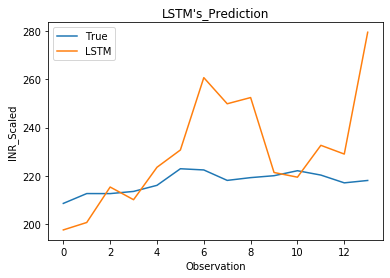

In [71]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()
